# Classification using Transfer Learning and Ensemble in PyTorch

This notebook implements a deep learning pipeline using transfer learning with ResNet-50, VGG-16, and EfficientNet-B0 on a balanced COVID-19 radiography dataset. The final classification result is obtained through ensemble learning.

In [ ]:

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


## Step 2: Dataset Preparation - Balancing Classes

In [ ]:

import shutil

# Paths
root_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
image_paths = {cls: glob(os.path.join(root_path, cls, "images", "*.png")) for cls in class_names}
min_samples = min(len(v) for v in image_paths.values())

print("Minimum samples per class for balancing:", min_samples)

# Sampling equal images and preparing data splits
balanced_data = []
for label, cls in enumerate(class_names):
    sampled = random.sample(image_paths[cls], min_samples)
    for img_path in sampled:
        balanced_data.append((img_path, label))

random.shuffle(balanced_data)


Minimum samples per class for balancing: 1345


## Step 3: Custom Dataset and Transformations

In [ ]:

class CovidDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split
split_ratio = 0.8
split_idx = int(split_ratio * len(balanced_data))
train_data = balanced_data[:split_idx]
val_data = balanced_data[split_idx:]

train_loader = DataLoader(CovidDataset(train_data, transform), batch_size=32, shuffle=True)
val_loader = DataLoader(CovidDataset(val_data, transform), batch_size=32, shuffle=False)


## Step 4: Transfer Learning Models

In [ ]:

def get_model(name):
    if name == "resnet":
        model = models.resnet50(weights='IMAGENET1K_V1')
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 4)
        )
    elif name == "vgg":
        model = models.vgg16(weights='IMAGENET1K_V1')
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)
        )
    elif name == "efficientnet":
        model = models.efficientnet_b0(weights='IMAGENET1K_V1')
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 4)
        )
    return model.to(device)


## Step 5: Training Function

In [ ]:

def train_model(model, name, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        train_acc.append(correct / total)
        train_loss.append(running_loss / len(train_loader))

        model.eval()
        correct, total, running_loss = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        val_acc.append(correct / total)
        val_loss.append(running_loss / len(val_loader))
        print(f"{name} - Epoch {epoch+1}/{epochs} - Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return model, (train_acc, val_acc, train_loss, val_loss)


## Step 6: Training and Evaluating All Models

In [ ]:

model_names = ['resnet', 'vgg', 'efficientnet']
models_trained, histories = {}, {}

for name in model_names:
    model = get_model(name)
    trained_model, history = train_model(model, name)
    models_trained[name] = trained_model
    histories[name] = history


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


resnet - Epoch 1/5 - Train Acc: 0.8569, Val Acc: 0.8773
resnet - Epoch 2/5 - Train Acc: 0.9512, Val Acc: 0.8857
resnet - Epoch 3/5 - Train Acc: 0.9693, Val Acc: 0.9377
resnet - Epoch 4/5 - Train Acc: 0.9840, Val Acc: 0.9303
resnet - Epoch 5/5 - Train Acc: 0.9803, Val Acc: 0.8764


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 230MB/s] 


vgg - Epoch 1/5 - Train Acc: 0.7914, Val Acc: 0.8996
vgg - Epoch 2/5 - Train Acc: 0.9240, Val Acc: 0.9275
vgg - Epoch 3/5 - Train Acc: 0.9324, Val Acc: 0.9191
vgg - Epoch 4/5 - Train Acc: 0.9654, Val Acc: 0.9638


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


vgg - Epoch 5/5 - Train Acc: 0.9747, Val Acc: 0.9572


100%|██████████| 20.5M/20.5M [00:00<00:00, 115MB/s] 


efficientnet - Epoch 1/5 - Train Acc: 0.7902, Val Acc: 0.9452
efficientnet - Epoch 2/5 - Train Acc: 0.9268, Val Acc: 0.9610
efficientnet - Epoch 3/5 - Train Acc: 0.9470, Val Acc: 0.9647
efficientnet - Epoch 4/5 - Train Acc: 0.9714, Val Acc: 0.9554
efficientnet - Epoch 5/5 - Train Acc: 0.9747, Val Acc: 0.9507


## Step 7: Plot Training Accuracy and Loss

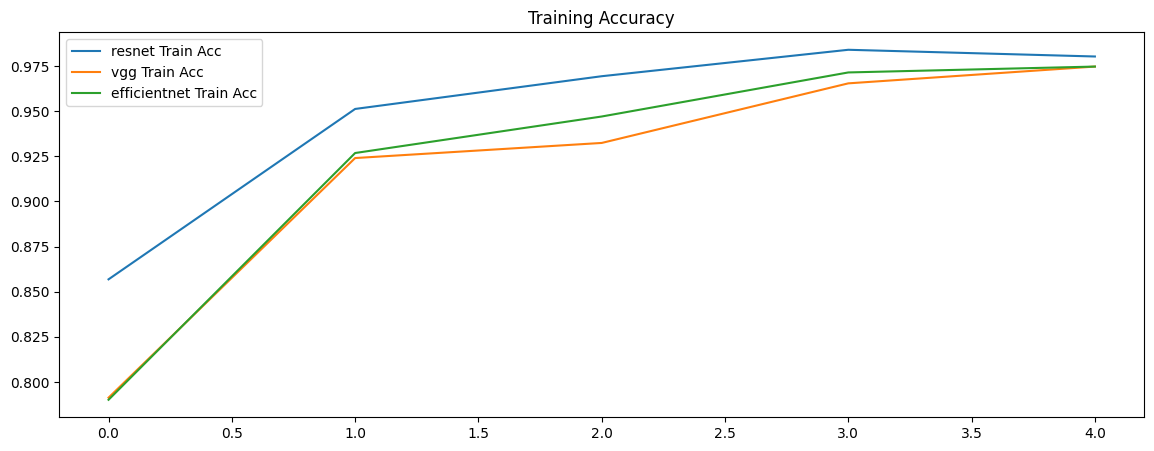

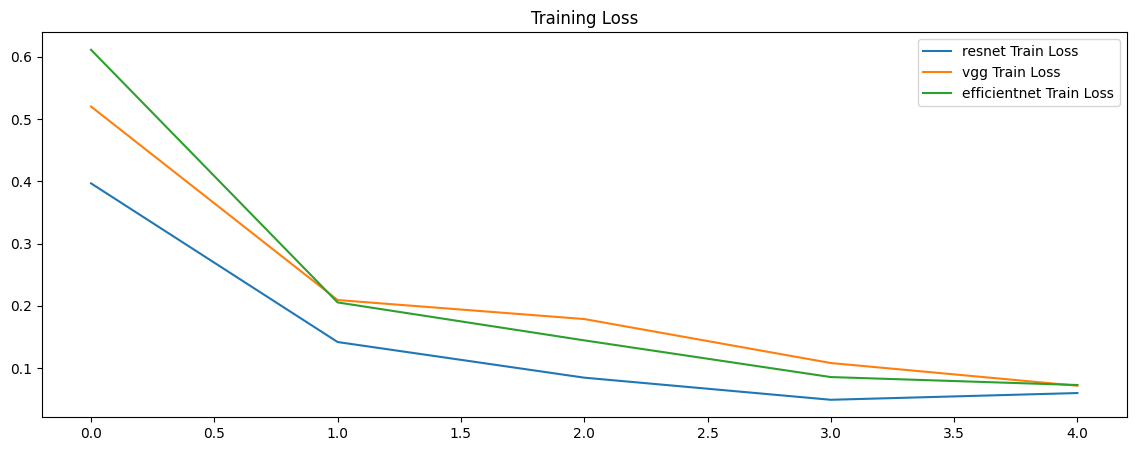

In [ ]:

plt.figure(figsize=(14, 5))
for name in model_names:
    plt.plot(histories[name][0], label=f'{name} Train Acc')
plt.title("Training Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
for name in model_names:
    plt.plot(histories[name][2], label=f'{name} Train Loss')
plt.title("Training Loss")
plt.legend()
plt.show()


## Step 8: Confusion Matrices and Ensemble

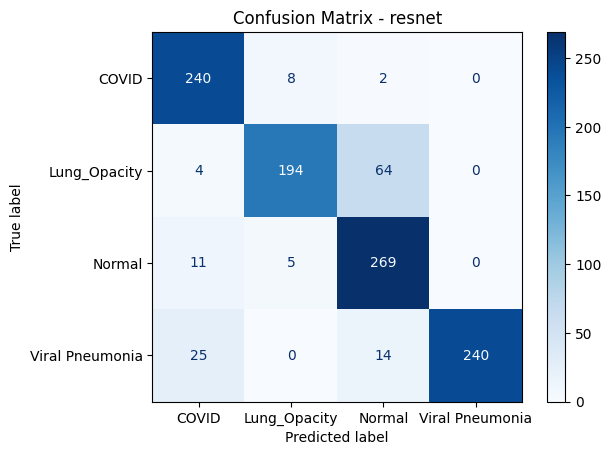

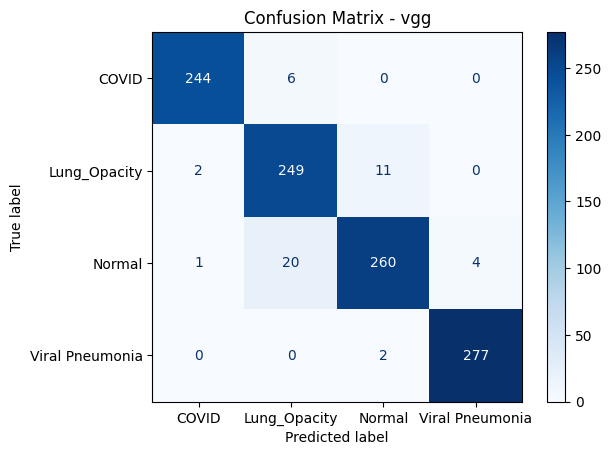

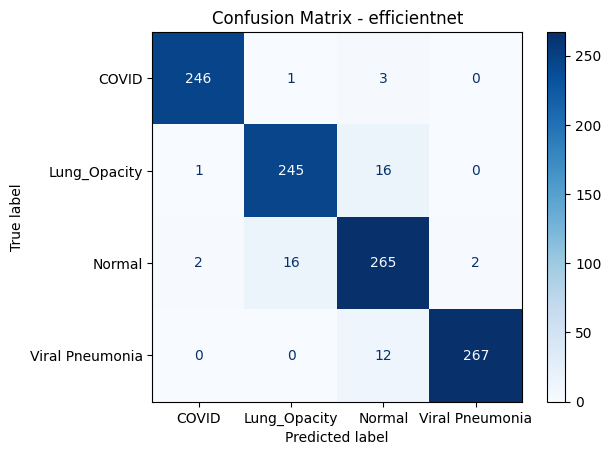

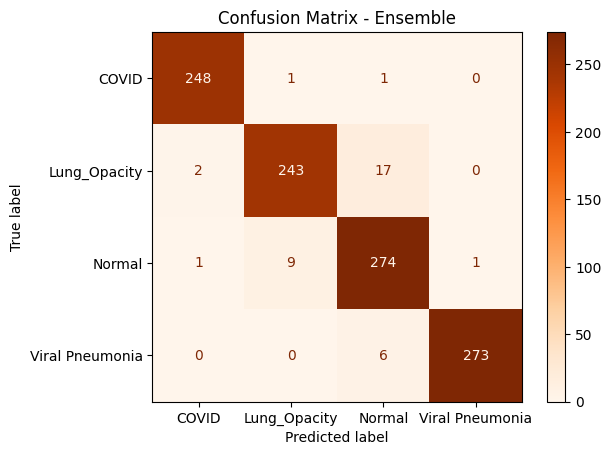

In [ ]:

def get_predictions(model):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            outputs = model(x)
            all_preds.append(outputs.cpu())
            all_labels.extend(y.cpu().numpy())
    return torch.cat(all_preds), np.array(all_labels)

# Predictions from all models
predictions = {}
for name in model_names:
    probs, labels = get_predictions(models_trained[name])
    predictions[name] = torch.softmax(probs, dim=1)

# Confusion Matrices
for name in model_names:
    preds = predictions[name].argmax(dim=1).numpy()
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Ensemble prediction (average)
ensemble_probs = sum(predictions.values()) / len(predictions)
ensemble_preds = ensemble_probs.argmax(dim=1).numpy()
ensemble_cm = confusion_matrix(labels, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=ensemble_cm, display_labels=class_names)
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix - Ensemble")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_metrics(predictions, labels, model_names, class_names):
    for name in model_names:
        preds = predictions[name].argmax(dim=1).numpy()
        print(f"\n{name.upper()} Metrics:")
        print(f"Accuracy:  {accuracy_score(labels, preds):.4f}")
        print(f"Precision: {precision_score(labels, preds, average='macro'):.4f}")
        print(f"Recall:    {recall_score(labels, preds, average='macro'):.4f}")
        print(f"F1-Score:  {f1_score(labels, preds, average='macro'):.4f}")
        print("Classification Report:\n", classification_report(labels, preds, target_names=class_names))

    # Ensemble
    ensemble_preds = (sum(predictions.values()) / len(predictions)).argmax(dim=1).numpy()
    print(f"\nEnsemble Metrics:")
    print(f"Accuracy:  {accuracy_score(labels, ensemble_preds):.4f}")
    print(f"Precision: {precision_score(labels, ensemble_preds, average='macro'):.4f}")
    print(f"Recall:    {recall_score(labels, ensemble_preds, average='macro'):.4f}")
    print(f"F1-Score:  {f1_score(labels, ensemble_preds, average='macro'):.4f}")
    print("Classification Report:\n", classification_report(labels, ensemble_preds, target_names=class_names))

# Call this after predictions are computed
evaluate_metrics(predictions, labels, model_names, class_names)



RESNET Metrics:
Accuracy:  0.8764
Precision: 0.8913
Recall:    0.8761
F1-Score:  0.8766
Classification Report:
                  precision    recall  f1-score   support

          COVID       0.86      0.96      0.91       250
   Lung_Opacity       0.94      0.74      0.83       262
         Normal       0.77      0.94      0.85       285
Viral Pneumonia       1.00      0.86      0.92       279

       accuracy                           0.88      1076
      macro avg       0.89      0.88      0.88      1076
   weighted avg       0.89      0.88      0.88      1076


VGG Metrics:
Accuracy:  0.9572
Precision: 0.9579
Recall:    0.9579
F1-Score:  0.9576
Classification Report:
                  precision    recall  f1-score   support

          COVID       0.99      0.98      0.98       250
   Lung_Opacity       0.91      0.95      0.93       262
         Normal       0.95      0.91      0.93       285
Viral Pneumonia       0.99      0.99      0.99       279

       accuracy                

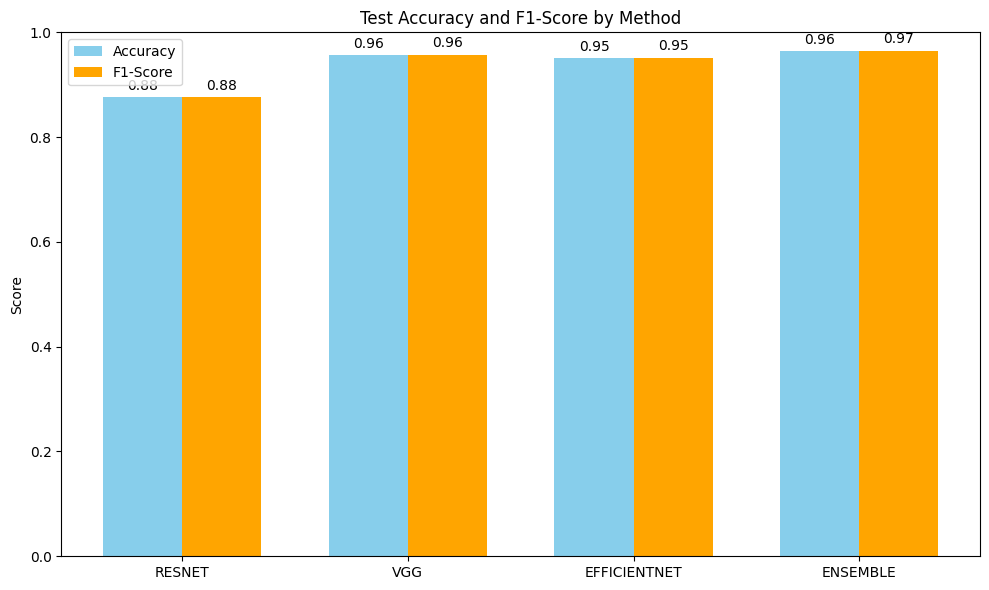

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_f1(predictions, labels, model_names):
    methods = model_names + ['ensemble']
    accuracy = []
    f1 = []

    for name in model_names:
        preds = predictions[name].argmax(dim=1).numpy()
        accuracy.append(accuracy_score(labels, preds))
        f1.append(f1_score(labels, preds, average='macro'))

    # Ensemble
    ensemble_preds = (sum(predictions.values()) / len(predictions)).argmax(dim=1).numpy()
    accuracy.append(accuracy_score(labels, ensemble_preds))
    f1.append(f1_score(labels, ensemble_preds, average='macro'))

    # Plot
    x = np.arange(len(methods))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue')
    bars2 = ax.bar(x + width/2, f1, width, label='F1-Score', color='orange')

    ax.set_ylabel('Score')
    ax.set_title('Test Accuracy and F1-Score by Method')
    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in methods])
    ax.set_ylim([0, 1])
    ax.legend()

    # Annotate bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Call this after predictions and labels are ready
plot_accuracy_f1(predictions, labels, model_names)


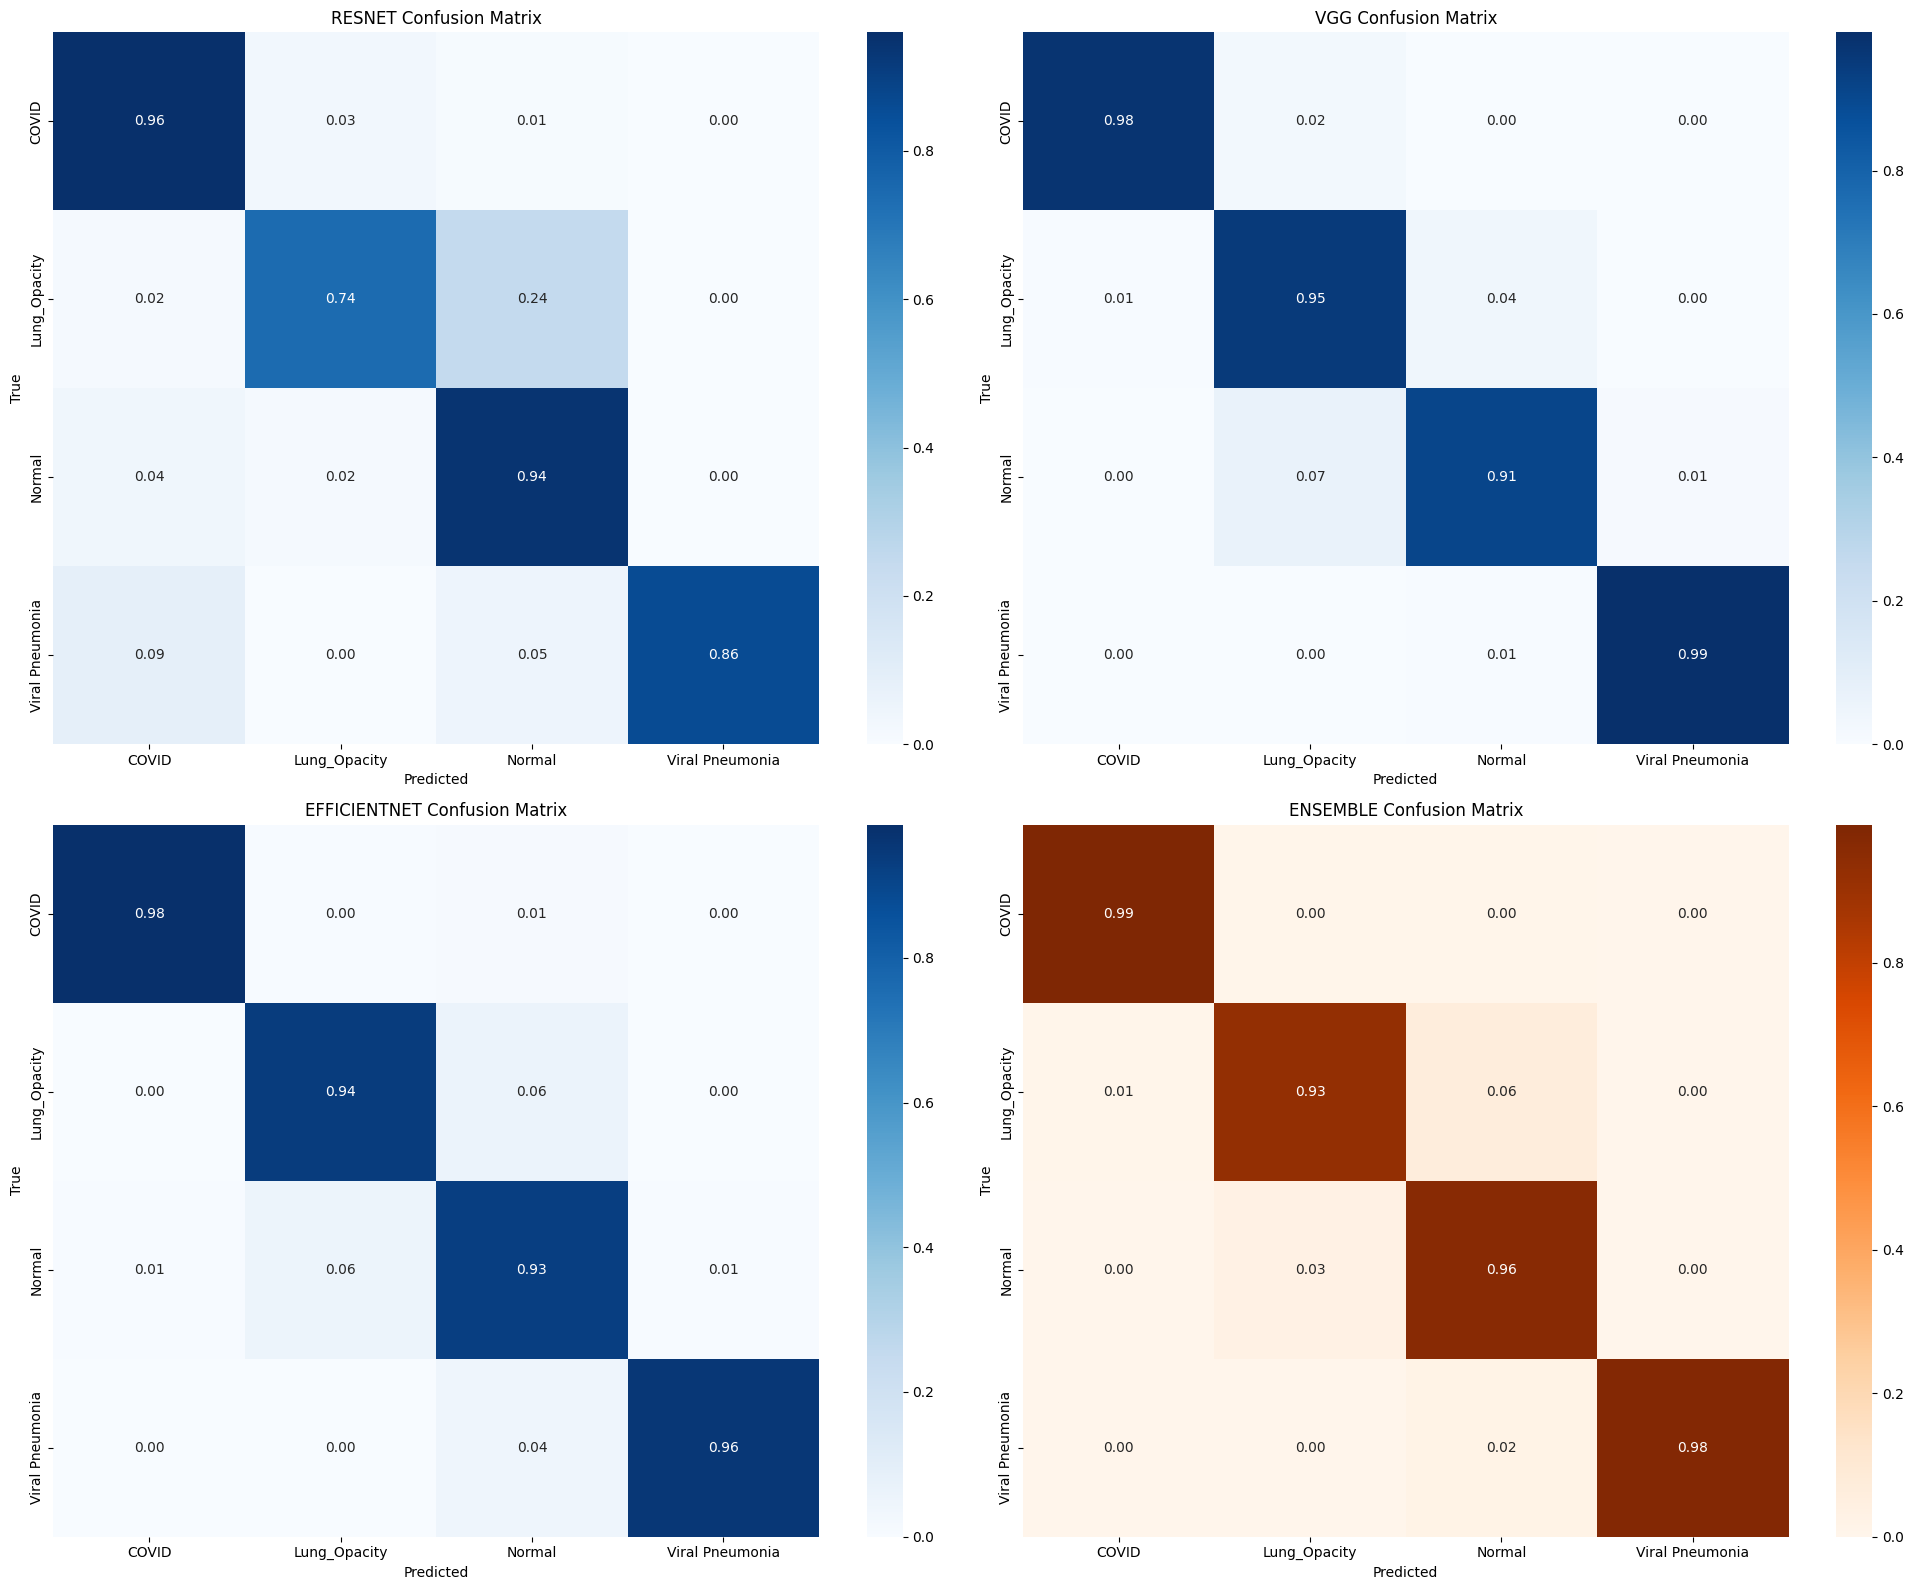

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_heatmaps(predictions, labels, model_names, class_names):
    plt.figure(figsize=(20, 16))
    for i, name in enumerate(model_names):
        preds = predictions[name].argmax(dim=1).numpy()
        cm = confusion_matrix(labels, preds, normalize='true')
        plt.subplot(2, 2, i+1)
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{name.upper()} Confusion Matrix')
        plt.xlabel("Predicted")
        plt.ylabel("True")

    # Ensemble
    ensemble_preds = (sum(predictions.values()) / len(predictions)).argmax(dim=1).numpy()
    cm = confusion_matrix(labels, ensemble_preds, normalize='true')
    plt.subplot(2, 2, 4)
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
    plt.title("ENSEMBLE Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.tight_layout()
    plt.show()

# Run this after computing predictions
plot_confusion_heatmaps(predictions, labels, model_names, class_names)
